# Training Deep Neural Networks on GPUs

Considering the application of a logistic regression model on th MNIST dataset, it's difficult to improve the accuracy beyond 87%, since the model assumes a linear relationship between pixel intensities and image labels. It is possible to improve upon it using a feed-forward neural network able to capture non-linear relationships between inputs and targets.

In [37]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Data import, split, and dataloaders

1. Import the MNIST dataset

In [38]:
dataset = MNIST(
    root='data/', 
    download=True, 
    transform=ToTensor()
)

2. Split the training set in training and validation

In [39]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, valid_ds = random_split(dataset, [train_size,val_size])
len(train_ds), len(valid_ds)

(50000, 10000)

3. Define the dataloaders

In [40]:
batch_size = 128
num_workers = 4

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers
)

train_loader = DataLoader(
    dataset=valid_ds,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=num_workers
)

Setting the argument `num_workers` as a positive integer will turn on multi-process data loading with the specified number of loader worker processes

Passing `pin_memory=True` to a DataLoader will automatically put the fetched data Tensors in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.

See https://pytorch.org/docs/stable/data.html#single-and-multi-process-data-loading

Visualize a batch of data in a grid using the `make_grid` function from `torchvision`. Also the `.permute` method has to be used on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

batch_0.shape: torch.Size([128, 1, 28, 28])


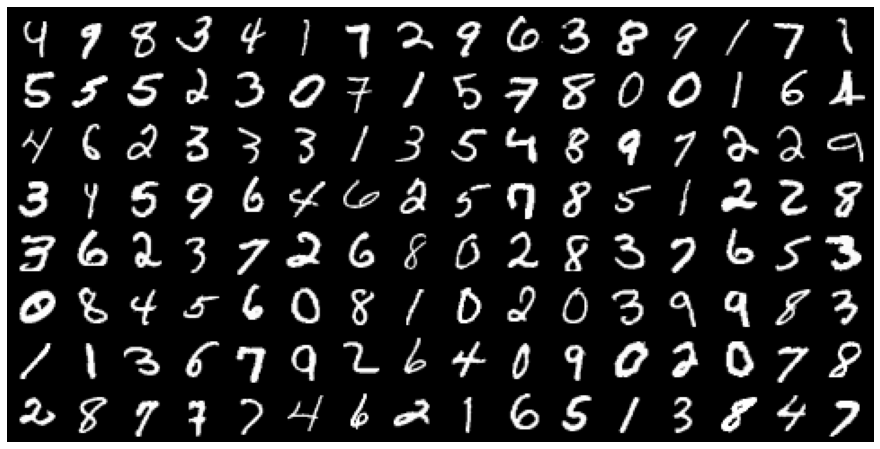

In [41]:
batch_0, _ = list(train_loader)[0]
print('batch_0.shape:', batch_0.shape)
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(make_grid(batch_0, nrow=16).permute((1, 2, 0)))

## Hidden Layers, Activation Functions and Non-Linearity

Create a neural network with two layers: 
- **hidden layer** 
- **output layer**

An **activation function** is going to be inserted between the two layers, to create a non-linear relationship

1. Consider a batch of inputs tensors, and flatten the `1x28x28` image tensors into vectors of size `784`, so they can be passed into an `nn.Linear` object. The flattening is performed using `torch.flatten` (see https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [42]:
batch_0, labels_0 = list(train_loader)[0]
print(batch_0.shape)
input_0 = torch.flatten(batch_0, start_dim=1)
print(input_0.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128, 784])


2. Define the model for the hidden layer using the `nn.Linear` class with the following parameters
    - the input size is equal to the length of the flattened tensors (784)
    - the output size (i.e. hidden size, in this case) is set to 32

In [43]:
input_size = input_0.shape[-1]
hidden_size = 32

layer1 = nn.Linear(
    in_features=input_size,
    out_features=hidden_size
)

hidden_0 = layer1(input_0)
hidden_0.shape

torch.Size([128, 32])

3. Apply the ReLU activation function
ReLU is a non-linear function, defined as
$$\text{ReLU}(x)=\max{(0,x)}$$
ReLU is implemented in PyTorch with the `relu` function

In [44]:
relu_0 = F.relu(hidden_0)

print(relu_0.shape)
print('min(layer1_outputs):', torch.min(hidden_0).item())
print('min(relu_outputs):', torch.min(relu_0).item())

torch.Size([128, 32])
min(layer1_outputs): -0.8030096292495728
min(relu_outputs): 0.0


4. Define the model for the output layer using the `nn.Linear` class with the following parameters
    - the input size is equal to the length of the ReLU output (that is the hidden layer length) 
    - the output size is set to the number of possible output classes

In [45]:
output_size = 10

layer2 = nn.Linear(hidden_size, output_size)

output_0 = layer2(relu_0)
output_0.shape

torch.Size([128, 10])

5. Compute the cross-entropy loss function

In [46]:
loss_0 = F.cross_entropy(output_0, labels_0)
loss_0

tensor(2.3268, grad_fn=<NllLossBackward0>)

## Model creation using the `nn.Module`

So, the non-linear model (i.e., the neural network) is composed of two `nn.Linear` objects, each one corresponding to a **layer** in the network, and a ReLU activation function between them
- the first layer (also known as the hidden layer) transforms the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64)
- a non-linear **activation function** is applied to the intermediate outputs. The activation function transforms individual elements of the matrix
- the result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer). The second layer transforms it into a matrix of size `batch_size x 10`
- the loss is computed on this output and weights and biases are updated using gradient descent

### The model
Define the *accuracy* metric, and then define the model by extending the `nn.Module` class from PyTorch.

In [48]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(torch.eq(preds,labels)).item() / len(preds))

In [49]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.flatten = nn.Flatten()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = self.flatten(xb)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))